# Intro to  Linear Regression with cuML

#### Installing RAPIDS AI

In [0]:
# pull RAPIDS AI install script from notebooks-contrib 
!wget -nc https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh
# install RAPIDS 0.10 nightly
!bash rapids-colab.sh 

import sys, os
# set up system for RAPIDS use
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

## Load data
- for this demo, we will be utilizing the Boston housing dataset from `sklearn`
  - start by loading in the set and printing a map of the contents

In [4]:
from sklearn.datasets import load_boston

# load Boston dataset
boston = load_boston()

# let's see what's inside
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


#### Boston house prices dataset
- a description of the dataset is provided in `DESCR`
  - let's explore 

In [26]:
# what do we know about this dataset?
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Prep Data
- Import `cuDF` and input the data into a DataFrame 
  - Then add a `PRICE` column equal to the `target` key

In [29]:
import cudf

# build dataframe from data key
bos = cudf.DataFrame(list(boston.data))
# set column names to feature_names
bos.columns = boston.feature_names

# add PRICE column from target
bos['PRICE'] = boston.target

# let's see what we're working with
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Simple Linear Regression
- For basic Linear Regression, we will predict `PRICE` (Median value of owner-occupied homes) based on `TAX` (full-value property-tax rate per $10,000)
  - Go ahead and trim data to just these columns

In [0]:
# simple linear regression X and Y
X = bos['TAX']
Y = bos['PRICE']

We can now set training and testing sets for our model
- Use `cuML`'s `train_test_split` to do this
  - Train on 70% of data
  - Test on 30% of data

In [41]:
from cuml.preprocessing.model_selection import train_test_split

# train/test split (70:30)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7)

# see what it looks like
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(354,)
(152,)
(354,)
(152,)


### Predict Values
1. fit the model with `TAX` (*X_train*) and corresponding `PRICE` (*y_train*) values 
  - so it can build an understanding of their relationship 
2. predict `PRICE` (*y_test*) for a test set of `TAX` (*X_test*) values
  - and compare `PRICE` predictions to actual median house (*y_test*) values
    - use `sklearn`'s `mean_squared_error` to do this
3. visualize with `matplotlib`

57.54759670027663


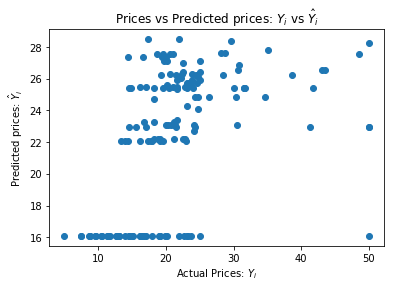

In [42]:
from cuml import LinearRegression
from sklearn.metrics import mean_squared_error

# call Linear Regression model
slr = LinearRegression()

# train the model
slr.fit(X_train, Y_train)

# make predictions for test X values
Y_pred = slr.predict(X_test)

# calculate error
mse = mean_squared_error(Y_test, Y_pred)
print(mse)

import matplotlib.pyplot as plt
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

plt.show()

## Multiple Linear Regression 
- Our mean squared error for Simple Linear Regression looks kinda high..
  - Let's try Multiple Linear Regression (predicting based on multiple variables rather than just `TAX`) and see if that produces more accurate predictions

1. Set X to contain all values that are not `PRICE` from the unsplit data
  - i.e. `CRIM`, `ZN`, `INDUS`, `CHAS`, `NOX`, `RM`, `AGE`, `DIS`, `RAD`, `TAX`, `PTRATIO`, `B`, `LSTAT`
  - Y to still represent just 1 target value (`PRICE`)
    - also from the unsplit data
2. Split the data into `multi_X_train`, `multi_X_test`, `Y_train`, and `Y_test`
  - Use `cuML`'s `train_test_split`
    - And the same 70:30 train:test ratio


In [43]:
# set X to all variables except price
X = bos.drop('PRICE', axis=1)
# and, like in the simple Linear Regression, set Y to price
Y = bos['PRICE']

from cuml.preprocessing.model_selection import train_test_split

multi_X_train, multi_X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(354, 13)
(152, 13)
(354,)
(152,)


2. fit the model with `multi_X_train` and corresponding `PRICE` (*y_train*) values 
  - so it can build an understanding of their relationships 
3. predict `PRICE` (*y_test*) for the test set of independent (*multi_X_test*) values
  - and compare `PRICE` predictions to actual median house (*y_test*) values
    - use `sklearn`'s `mean_squared_error` to do this
3. visualize with `matplotlib`

16.89680588733403


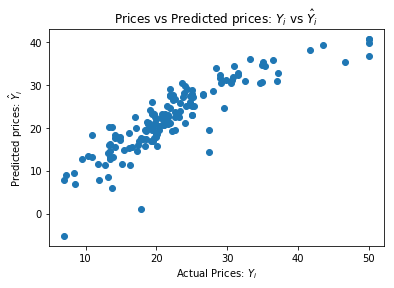

In [45]:
# call Linear Regression model
mlr = LinearRegression()

# train the model for multiple regression
mlr.fit(X_train, Y_train)

# make predictions for test X values
Y_pred = mlr.predict(X_test)

# calculate error
mse = mean_squared_error(Y_test, Y_pred)
print(mse)

plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

## Conclusion
- is recording and processing the extra information for multiple regression worth it?
  - yes, very much

In [8]:
# is the multi regression model better?
worth = simple_MSE >= multi_MSE

if worth == True:
  diff = simple_MSE - multi_MSE
  print('totally worth -- MULTIPLE REGRESSION wins\n\n'
        'multiple regression produces more accurate predictions\n' 
        f'by a difference of {diff}')
  
if worth == False:
  diff = multi_MSE - simple_MSE
  print('not worth -- LINEAR REGRESSION wins\n\n'
        'simple regression produces more accurate predictions' 
        f'by a difference of {diff}')

not worth -- LINEAR REGRESSION wins

simple regression produces more accurate predictionsby a difference of 6.235387054074911e+18


- looks like the multiple regression we ran provides more accurate predictions than the simple linear regression
  - this will not always be the case
    - so always be sure to check and confirm if the extra computing is worth it

Anyways, that's how you implement both Simple and Multiple Linear Regression with `cuML`. Go forth and do great things. Thanks for stopping by!

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


(506, 13)


In [5]:
print(boston.data.shape)
print(boston.feature_names)
print(boston.DESCR)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

        0     1     2    3      4   ...   8      9     10      11    12
0  0.00632  18.0  2.31  0.0  0.538  ...  1.0  296.0  15.3  396.90  4.98
1  0.02731   0.0  7.07  0.0  0.469  ...  2.0  242.0  17.8  396.90  9.14
2  0.02729   0.0  7.07  0.0  0.469  ...  2.0  242.0  17.8  392.83  4.03
3  0.03237   0.0  2.18  0.0  0.458  ...  3.0  222.0  18.7  394.63  2.94
4  0.06905   0.0  2.18  0.0  0.458  ...  3.0  222.0  18.7  396.90  5.33

[5 rows x 13 columns]


      CRIM    ZN  INDUS  CHAS    NOX  ...  RAD    TAX  PTRATIO       B  LSTAT
0  0.00632  18.0   2.31   0.0  0.538  ...  1.0  296.0     15.3  396.90   4.98
1  0.02731   0.0   7.07   0.0  0.469  ...  2.0  242.0     17.8  396.90   9.14
2  0.02729   0.0   7.07   0.0  0.469  ...  2.0  242.0     17.8  392.83   4.03
3  0.03237   0.0   2.18   0.0  0.458  ...  3.0  222.0     18.7  394.63   2.94
4  0.06905   0.0   2.18   0.0  0.458  ...  3.0  222.0     18.7  396.90   5.33

[5 rows x 13 columns]


      CRIM    ZN  INDUS  CHAS    NOX  ...    TAX  PTRATIO       B  LSTAT  PRICE
0  0.00632  18.0   2.31   0.0  0.538  ...  296.0     15.3  396.90   4.98   24.0
1  0.02731   0.0   7.07   0.0  0.469  ...  242.0     17.8  396.90   9.14   21.6
2  0.02729   0.0   7.07   0.0  0.469  ...  242.0     17.8  392.83   4.03   34.7
3  0.03237   0.0   2.18   0.0  0.458  ...  222.0     18.7  394.63   2.94   33.4
4  0.06905   0.0   2.18   0.0  0.458  ...  222.0     18.7  396.90   5.33   36.2

[5 rows x 14 columns]


Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'PRICE'],
      dtype='object')

(354,)
(152,)
(354,)
(152,)
77.01165305309908


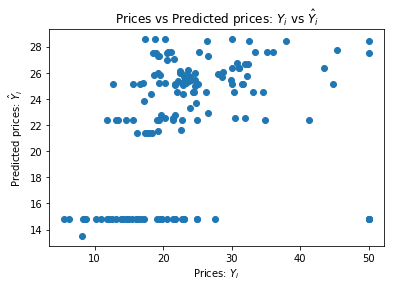

In [39]:
X = bos['TAX']
Y = bos['PRICE']

from cuml.preprocessing.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

from cuml import LinearRegression
lm = LinearRegression()
lm.fit(X_train, Y_train)
Y_pred = lm.predict(X_test)

import matplotlib.pyplot as plt
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)
print(mse)

(354, 13)
(152, 13)
(354,)
(152,)
19.87896394224548


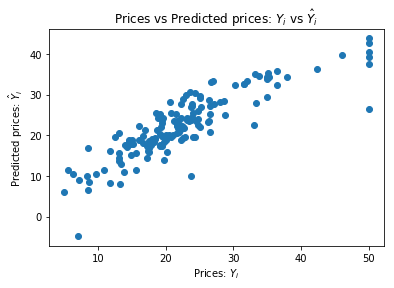